# PyHMA: Python implementations of the Hydrograph Matching Algorithm
For introduction of the HMA see:
* Ewen, John. “Hydrograph Matching Method for Measuring Model Performance.” Journal of Hydrology 408, no. 1–2 (September 2011): 178–87. https://doi.org/10.1016/j.jhydrol.2011.07.038.

In summary, the article presents a method for identifying matching observed and simulated points in a way similar to how a hydrologist might compare to hydrographs. This is done by calculating (1) the 'work' for different (obs, sim) pairs, i.e. a distance measure based either on squared or absolute differences in magnitude and time and (2) identifying an optimal path to connect 0-2 simulation points to each observations that minimizes the cumulative work needed.

This package includes several implementations with different requirements on CPU time and RAM:
* calc_orig() follows exactly the pseudo-code from Ewen

The other implementations partially vectorize the computation, and:
* calc_sparse() uses sparse matrices for the cumulative work (CW) to reduce memory useage, at the cost of CPU time.
* calc_dense() uses dense matrices for CW to lower CPU time, but higher memory useage.
* calc_dense2() only maintains a single column of the CW matrix in memory, for best CPU time and RAM useage, but as a result the CW matrix is not available to check its accuracy and it is not possible to plot the connecting rays between sim and obs points.

These implementations also include support for non-constant time steps.

Note that all implementations except dense2 utilize a matrix of size (n, n, 2) for n observation time steps, so memory availability can become a limiting factor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyHMA import HMA

# Test case A: example from Appendix A to Ewen (2014)
The figures should all reproduce Figure 1 from Ewen. Note that it is not possible to draw the figure for dense2

..\PyHMA\__init__.py:258: RuntimeWarning: All-NaN slice encountered
  cw0[iss:ise, i_o] = (e + np.nanmin(points, axis=1)).reshape(len(e), 1)
c:\users\icobro\python\wpy-3710\python-3.7.1.amd64\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
..\PyHMA\__init__.py:441: RuntimeWarning: All-NaN slice encountered
  cw0[iss:ise, i_o] = (e + np.nanmin(points, axis=1))
..\PyHMA\__init__.py:531: RuntimeWarning: All-NaN slice encountered
  cw0_cur[iss:ise] = (e + np.nanmin(points, axis=1))
..\PyHMA\__init__.py:534: RuntimeWarning: invalid value encountered in greater
  nz0 = cw0_cur[cw0_cur > 1].min()
..\PyHMA\__init__.py:535: RuntimeWarning: invalid value encountered in greater
  nz1 = cw1_cur[cw1_cur > 1].min()


,Fsim,sum(cw)
Ewen,0.848,130759
orig,0.848275,130759.0
sparse,0.848275,130759.0
dense,0.848275,130759.0
dense2,0.848275,NaN


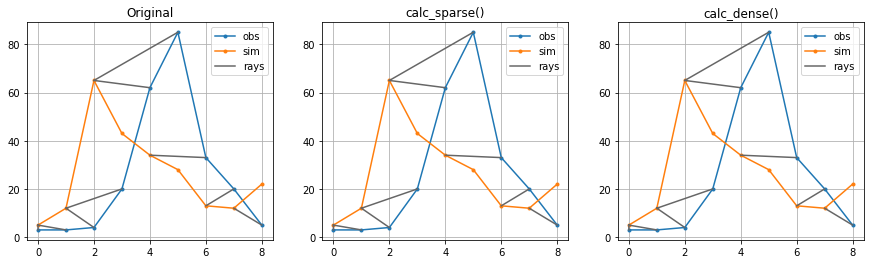

In [55]:
qoA = np.array([3,  3,  4, 20, 62, 85, 33, 20,  5], dtype=float)
qsA = np.array([5, 12, 65, 43, 34, 28, 13, 12, 22], dtype=float)
hA = HMA(qoA, qsA, b=4, max_lag=1, max_lead=3, measure='nse', keep_internals=True, calc_rays=True)

df = pd.DataFrame(index=['Ewen', 'orig', 'sparse', 'dense', 'dense2'],
                  columns=['Fsim', 'sum(cw)'], dtype='object'
                 )

df.loc['Ewen'] = 0.848, 130759.0
fig, axes = plt.subplots(1, 3, figsize=(15,4))

fsim = hA.calc_orig()
df.loc['orig'] = [fsim, np.nansum(hA.cw).astype(str)]
hA.plot(ax=axes[0])
axes[0].set_title('Original')

fsim = hA.calc_sparse()
df.loc['sparse'] = [fsim, np.nansum(hA.cw).astype(str)]
hA.plot(ax=axes[1])
axes[1].set_title('calc_sparse()')

fsim = hA.calc_dense()
df.loc['dense'] = [fsim, np.nansum(hA.cw).astype(str)]
hA.plot(ax=axes[2])
axes[2].set_title('calc_dense()')

hA.keep_internals = False
hA.calc_rays = False
fsim = hA.calc_dense2()
df.loc['dense2'] = [fsim, np.nan]

df

# Test case B: synthetic data

In [3]:
# Route some rain data (SMHI, beginning of 2020 for Luleå) through a linear reservoir
prec = np.loadtxt('test_data\\prec_data.txt', delimiter=',') * 1.5
k = 5 
qoB = prec * 0
qoB[0] = 0.2
for i in range(1, len(prec)):
    qoB[i] = (prec[i-1] + qoB[i-1] * (k - .5)) / (k + .5)

k = 8
qsB = prec * 0
for i in range(1, len(prec)):
    qsB[i] = (prec[i-1] + (1.05*qsB[i-1] - .5) * (k - .5)) / (k + .5)
qsB = np.hstack([0, 0, qsB[:-2]])

,Fsim,sum(cw)
orig,-3.05402,14619087336.482708
sparse,-3.05402,14619087336.482708
dense,-3.05402,14619087336.482708
dense2,-3.05402,NaN


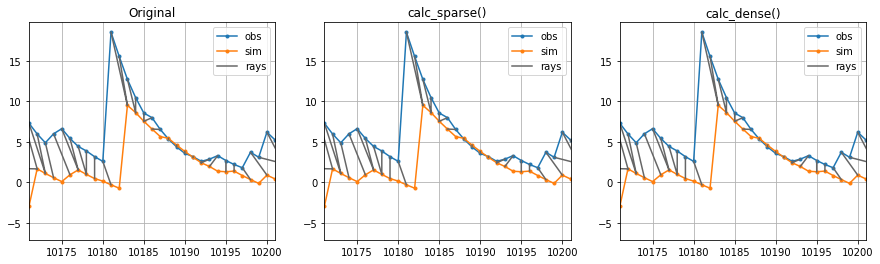

In [4]:
hB = HMA(qoB, qsB, b=.5, max_lag=3, max_lead=3, measure='square', keep_internals=True, calc_rays=True)

df = pd.DataFrame(index=['orig', 'sparse', 'dense', 'dense2'],
                  columns=['Fsim', 'sum(cw)'], dtype='object'
                 )

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True)

fsim = hB.calc_orig()
df.loc['orig'] = [fsim, np.nansum(hB.cw).astype(str)]
hB.plot(ax=axes[0])
axes[0].set_title('Original')

fsim = hB.calc_sparse()
df.loc['sparse'] = [fsim, np.nansum(hB.cw).astype(str)]
hB.plot(ax=axes[1])
axes[1].set_title('calc_sparse()')

fsim = hB.calc_dense()
df.loc['dense'] = [fsim, np.nansum(hB.cw).astype(str)]
hB.plot(ax=axes[2])
axes[2].set_title('calc_dense()')

hB.keep_internals = False
hB.calc_rays = False
fsim = hB.calc_dense2()
df.loc['dense2'] = [fsim, np.nan]
_ = axes[0].set_xlim(np.argmax(qoB)-10, np.argmax(qoB)+20)

df

In [5]:
%%timeit
hB.calc_orig()

5.71 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
hB.calc_sparse()

9.33 s ± 699 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
hB.calc_dense()

1.93 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
hB.calc_dense2()

715 ms ± 52.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
